In [1]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass
import warnings
sns.set()

pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [2]:
path = 'hedge_fund_replication.xlsx'
df_hedge_rep = pd.read_excel(path, sheet_name='HEDGE-REP').set_index('Dates')
df_merrill_facs = pd.read_excel(path, sheet_name='MERRILL-FACS').set_index('Dates')
df_multi_asset = pd.read_excel(path, sheet_name='MULTI-ASSET').set_index('Dates')


In [4]:

## Use slighty updated code from previous HW
@dataclass
class RegressionsOutput:
    excess_ret_stats: pd.DataFrame
    params: pd.DataFrame
    residuals: pd.DataFrame
    tstats: pd.DataFrame
    other: pd.DataFrame
    df: pd.DataFrame

def lfm_time_series_regression(df, portfolio_names, factors, annualize_factor=12):
    excess_ret_stats = pd.DataFrame(index=factors, columns=['average', 'std'], dtype=float)
    for factor in factors:
        excess_ret_stats.loc[factor, 'average'] = annualize_factor * df[factor].mean()
        excess_ret_stats.loc[factor, 'std'] = np.sqrt(annualize_factor) * df[factor].std()
        excess_ret_stats.loc[factor, 'sharpe_ratio'] = \
            excess_ret_stats.loc[factor, 'average'] / excess_ret_stats.loc[factor, 'std']
        # Here I'll just report the unscaled skewness
        excess_ret_stats.loc[factor, 'skewness'] = df[factor].skew()
        # excess_ret_stats.loc[factor, 'skewness'] = annualize_factor * df[factor].skew()

    _temp_excess_ret_stats = excess_ret_stats.copy()
    _temp_excess_ret_stats.loc['const', :] = 0

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        rhs = sm.add_constant(df[factors])
    df_params = pd.DataFrame(columns=portfolio_names)
    df_other = pd.DataFrame(columns=portfolio_names)
    df_residuals = pd.DataFrame(columns=portfolio_names)
    df_tstats = pd.DataFrame(columns=portfolio_names)
    for portfolio in portfolio_names:
        lhs = df[portfolio]
        res = sm.OLS(lhs, rhs, missing='drop').fit()
        df_params[portfolio] = res.params
        df_params.loc['const', portfolio] = annualize_factor * res.params['const']
        df_other.loc['r_squared', portfolio] = res.rsquared
        df_other.loc['model_implied_excess_ret', portfolio] = df_params[portfolio] @ _temp_excess_ret_stats['average']
        df_other.loc['ave_excess_ret', portfolio] = \
            annualize_factor * df[portfolio].mean()
        df_other.loc['std_excess_ret', portfolio] = \
            np.sqrt(annualize_factor) * df[portfolio].std()
        df_other.loc['skewness_excess_ret', portfolio] = \
            annualize_factor * df[portfolio].skew()
        df_other.loc['sharpe_ratio', portfolio] = \
            df_other.loc['ave_excess_ret', portfolio] / df_other.loc['std_excess_ret', portfolio]
        df_residuals[portfolio] = res.resid
        df_tstats[portfolio] = res.tvalues

    regression_outputs = RegressionsOutput(
        excess_ret_stats.T,
        df_params.T,
        df_residuals,
        df_tstats.T,
        df_other.T,
        df)


    return regression_outputs


# Section 2

## Problem 1

### (a) - (d)

In [5]:
hedge_rep_portfolio_names = ['HFRIFWI Index', 'MLEIFCTR Index',
    'MLEIFCTX Index', 'HDG US Equity', 'QAI US Equity', 'SPY US Equity']

hedge_rep_regs = lfm_time_series_regression(
    df=df_hedge_rep,
    portfolio_names=hedge_rep_portfolio_names,
    factors=['SPY US Equity']
    )

# I'm assuming returns are given as excess returns
# TODO: Check this.

def create_table1(regs_object):
    table1 = pd.DataFrame(
        regs_object.other[['ave_excess_ret', 'std_excess_ret', 'sharpe_ratio']])
    table1['Mkt beta'] = regs_object.params['SPY US Equity']
    table1['Mkt Corr'] = regs_object.df.corr()['SPY US Equity']
    return table1

table1 = create_table1(hedge_rep_regs)
table1

,ave_excess_ret,std_excess_ret,sharpe_ratio,Mkt beta,Mkt Corr
HFRIFWI Index,0.0325,0.0470,0.6920,0.3521,0.8943
MLEIFCTR Index,0.0300,0.0467,0.6411,0.3631,0.9271
MLEIFCTX Index,0.0281,0.0467,0.6013,0.3631,0.9272
HDG US Equity,0.0186,0.0494,0.3762,0.3709,0.8967
QAI US Equity,0.0213,0.0405,0.5242,0.2808,0.8262
SPY US Equity,0.1298,0.1193,1.0876,1.0000,1.0000


## Problem 2

### (a)  How do the perform since the case in 2013?

In [6]:
hedge_rep_regs_post_2013 = lfm_time_series_regression(
    df=df_hedge_rep['2014':], #Include 2014, not 2013
    portfolio_names=hedge_rep_portfolio_names,
    factors=['SPY US Equity']
    )

table2 = create_table1(hedge_rep_regs_post_2013)
table2

,ave_excess_ret,std_excess_ret,sharpe_ratio,Mkt beta,Mkt Corr
HFRIFWI Index,0.0307,0.0426,0.7200,0.3323,0.8981
MLEIFCTR Index,0.0295,0.0429,0.6891,0.3510,0.9426
MLEIFCTX Index,0.0275,0.0429,0.6418,0.3512,0.9424
HDG US Equity,0.0178,0.0432,0.4120,0.3497,0.9327
QAI US Equity,0.0157,0.0399,0.3940,0.2906,0.8392
SPY US Equity,0.1092,0.1151,0.9480,1.0000,1.0000


### (b) Does HDG outpeform its competitor, QAI?

See other written solutions and see figures above.

### (c) How do they compare to the S&P 500?

See figures above.

## Problem 3
Report the correlation matrix for these assets based on the full sample...

In [7]:
df_hedge_rep.corr()

,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity,SPY US Equity
HFRIFWI Index,1.0000,0.9167,0.9172,0.8868,0.8384,0.8943
MLEIFCTR Index,0.9167,1.0000,1.0000,0.9785,0.8347,0.9271
MLEIFCTX Index,0.9172,1.0000,1.0000,0.9785,0.8350,0.9272
HDG US Equity,0.8868,0.9785,0.9785,1.0000,0.8099,0.8967
QAI US Equity,0.8384,0.8347,0.8350,0.8099,1.0000,0.8262
SPY US Equity,0.8943,0.9271,0.9272,0.8967,0.8262,1.0000


## Problem 4

Replicate HFRI with the six factors listed on the "MERRIL_FACS" tab. Include...

In [8]:
merrill_factors = ['SPY US Equity', 'USGG3M Index', 'EEM US Equity',
    'EFA US Equity', 'EUO US Equity', 'IWM US Equity']

df_merrill_facs['HFRIFWI Index'] = df_hedge_rep['HFRIFWI Index']
prob4_regs = lfm_time_series_regression(
    df=df_merrill_facs,
    portfolio_names=['HFRIFWI Index'],
    factors=merrill_factors
    )

### (a) Report the intercept and betas.

In [9]:
prob4_regs.params

,const,SPY US Equity,USGG3M Index,EEM US Equity,EFA US Equity,EUO US Equity,IWM US Equity
HFRIFWI Index,0.0011,0.1204,0.1407,0.0571,0.1028,0.0206,0.0642


### (b) Are th ebetas realistic position sizes, or do they require ...

See other written solutions.

### (c) Report the R-squared

In [10]:
prob4_regs.other

,r_squared,model_implied_excess_ret,ave_excess_ret,std_excess_ret,skewness_excess_ret,sharpe_ratio
HFRIFWI Index,0.8721,0.0314,0.0325,0.0470,-7.8743,0.6920


### (d) Report the volatility of $\epsilon^{\text{merr}}$, (the tracking error).

In [11]:
prob4_regs.residuals.std() * np.sqrt(12)

HFRIFWI Index   0.0168
dtype: float64

## Problem 5

Replicate HFRI with the factors listed on the "MULTI-ASSET" tab. Include...

In [11]:
multi_asset_factors = ['SPY US Equity', 'PSP US Equity', 'HYG US Equity',
    'SPGSCITR Index', 'IYR US Equity', 'IEF US Equity', 'BWX US Equity',
    'TIP US Equity', 'SHV US Equity']
df_multi_asset['HFRIFWI Index'] = df_hedge_rep['HFRIFWI Index']
prob5_regs = lfm_time_series_regression(
    df=df_multi_asset,
    portfolio_names=['HFRIFWI Index'],
    factors=multi_asset_factors
    )

### (a) - (d)

In [12]:
# Report the intercept and betas.
prob5_regs.params

,const,SPY US Equity,PSP US Equity,HYG US Equity,SPGSCITR Index,IYR US Equity,IEF US Equity,BWX US Equity,TIP US Equity,SHV US Equity
HFRIFWI Index,-0.0017,0.1818,0.1665,-0.0903,0.0351,-0.0173,0.0718,-0.0095,0.0829,-0.0082


In [13]:
# Report the R-squared
prob5_regs.other

,r_squared,model_implied_excess_ret,ave_excess_ret,std_excess_ret,skewness_excess_ret,sharpe_ratio
HFRIFWI Index,0.8990,0.0342,0.0325,0.0470,-7.8743,0.6920


In [14]:
# Report the volatility of $\epislon^{\text{merr}}$, (the tracking error).
prob5_regs.residuals.std() * np.sqrt(12)

HFRIFWI Index   0.0149
dtype: float64

## Problem 6

### (a) Which replication is better?

See other solutions.

### (b) Does either replication do a better job tracking HFRI than HDG?

See other solutions.

## Problem 7

Let's take a serious look at the out-of-sample performace...

In [15]:
date_range = df_merrill_facs['01-2015':'09-2019'].index
oos_fitted = pd.Series(index=date_range, name='OOS_fit')
for date in date_range:
    # Note: Altenate code doesn't account for uneven number of days in a month
    # date - pd.Timedelta(value=1, unit='M')
    date_month_prior = pd.DatetimeIndex([date]).shift(periods=-1, freq='M')[0]
    df_subset = df_merrill_facs[:date_month_prior]
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        rhs = sm.add_constant(df_subset[merrill_factors])
    lhs = df_subset['HFRIFWI Index']
    res = sm.OLS(lhs, rhs, drop="missing").fit()
    alpha = res.params['const']
    beta = res.params.drop(index='const')
    x_t = df_merrill_facs.loc[date, merrill_factors]
    predicted_next_value = alpha + x_t @ beta
    oos_fitted[date] = predicted_next_value


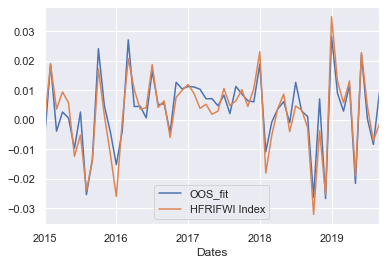

In [16]:
oos_fitted['01-2015':].plot()
df_merrill_facs.loc['01-2015':,'HFRIFWI Index'].plot()
plt.legend();

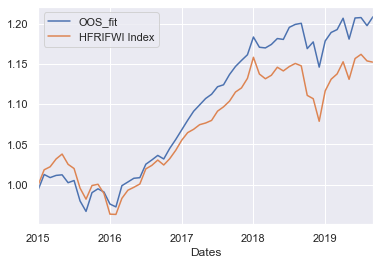

In [17]:
(oos_fitted['01-2015':] + 1).cumprod().plot()
(df_merrill_facs.loc['01-2015':,'HFRIFWI Index'] + 1).cumprod().plot()
plt.legend();

In [18]:
(pd.DataFrame(
    [oos_fitted, df_merrill_facs.loc['01-2015':,'HFRIFWI Index']])
    ).T.corr()

,OOS_fit,HFRIFWI Index
OOS_fit,1.0000,0.9306
HFRIFWI Index,0.9306,1.0000
